In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tensorflow as tf
import time
from pylab import *
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage.util.shape import view_as_windows
from sklearn.metrics import roc_curve,roc_auc_score
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Conv2D, Layer, Lambda, Flatten
from tensorflow.keras import Input, Model, metrics
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
train_source = os.path.abspath(os.path.join('../../data/train_source/'))
test_source = os.path.abspath(os.path.join('../../data/test_source/'))
train_path = os.path.abspath(os.path.join('../../data/train/'))
test_path = os.path.abspath(os.path.join('../../data/test/'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
    
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
#print(device_lib.list_local_devices())

In [ ]:
# Hyperparameters
nb_classes=2
cols, rows = 2, 30
input_shape = (cols, rows, 1)
vol_imb_diff = 0.1
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
num_frames = 2
h = 30
w = 2
d = 2

In [ ]:
X_train = np.load(train_source + str(num_frames) + '_X_train.npy')
Y_train = np.load(train_source + str(num_frames) + '_Y_train.npy')
F_train = np.load(train_source + str(num_frames) + '_F_train.npy')
X_test = np.load(train_source + str(num_frames) + '_X_test.npy')
Y_test = np.load(train_source + str(num_frames) + '_Y_test.npy')
F_test = np.load(train_source + str(num_frames) + '_F_test.npy')

### Run this When Experimenting ONLY

In [ ]:
def retrieve_cleansed_data(lob, width, filtered=True):
    min_max_scaler = MinMaxScaler(feature_range=(0,50))
    quantile_transformer = QuantileTransformer()
    
    # As evidenced by above, we can technically select all in the second axis as there is only 1 element. However, 
    # because we need a 2d input we make it 0. The 3rd axis is side so we need this
    lob_qty_buy = pd.DataFrame(lob['quantity'][:,0,0,0:20])
    lob_qty_buy = lob_qty_buy.replace(0, np.NaN)
    avg_buy = lob_qty_buy.mean().mean()
    vol_sum_buy = lob_qty_buy.sum(axis=1)
    
    lob_qty_sell = pd.DataFrame(lob['quantity'][:,0,1,0:20])
    lob_qty_sell = lob_qty_sell.replace(0, np.NaN)
    avg_sell = lob_qty_sell.mean().mean()
    vol_sum_sell = lob_qty_sell.sum(axis=1)

    vol_imbalance = (vol_sum_buy - vol_sum_sell) / (vol_sum_buy + vol_sum_sell)
    
    # Imbalance tips. The only way this can happen is if a new order comes in or deletes. 
    
    label_df = pd.concat([vol_imbalance, pd.Series(lob['action'].ravel()), pd.Series(lob['side'].ravel())], axis=1)
    label_df[3] = label_df[0].diff() # Change in the values of the two states of OB (We take diff of prev row)
    label_df[4] = 0
    label_df[4] = np.where(((label_df[1] == 2) & (label_df[2] == 'B') & (np.abs(label_df[3]) > vol_imb_diff)), 1, 
                  np.where(((label_df[1] == 2) & (label_df[2] == 'S') & (np.abs(label_df[3]) > vol_imb_diff)), 2, 
                             label_df[4].values))
    label_df = label_df.iloc[width-1:]
    Y_labels = label_df[4].reset_index(drop=True)
    X_feature = np.abs(label_df[3]).reset_index(drop=True)
   
    # Normalise positive samples
    # these array manipulations are to get a final array where b-s in same array group
    lob_n, d, w, h = lob['quantity'].shape
    b_qty = lob['quantity'][:,0,0,:]
    s_qty = lob['quantity'][:,0,1,:]
    lob_qty = np.stack((b_qty, s_qty), axis=2)

    lob_qty = lob_qty.reshape(-1,1)
    lob_qty = min_max_scaler.fit_transform(lob_qty)
    lob_qty = lob_qty.reshape(lob_n, h, w)
    
    b_price = lob['price'][:,0,0,:]
    s_price = lob['price'][:,0,1,:]
    lob_price = np.stack((b_price, s_price), axis=2)

    lob_price = lob_price.reshape(-1,1)
    lob_price = quantile_transformer.fit_transform(lob_price)
    lob_price = lob_price.reshape(lob_n, h, w)

    lob_states = np.dstack((lob_qty, lob_price))
    lob_states = lob_states.reshape(lob_n, h, w, 2)
    lob_states = view_as_windows(lob_states,(width,1,1,1))[...,0,0,0].transpose(0,4,1,2,3)
    
    if filtered:
        Y_labels = Y_labels[(Y_labels==1) | (Y_labels==2)]
        lob_states = lob_states[Y_labels.index]
        X_feature = X_feature[Y_labels.index]
        Y_labels = Y_labels.reset_index(drop=True)
        X_feature = X_feature.reset_index(drop=True)
        print(lob_states.shape)
    return lob_states, Y_labels, X_feature

In [ ]:
train = np.load(project_path + '/data/train_source/SPY_NASDAQ.npy')
test = np.load(project_path + '/data/test_source/VOD_BATS.npy')
X_train, Y_train, X_feature = retrieve_cleansed_data(train, 2)
X_test, Y_test, X_test_feature = retrieve_cleansed_data(test, 2)

In [ ]:
two = Y_test[Y_test==2]
one = Y_test[Y_test==1]
#print(X_train[0])
two

### Model Initialisation

In [ ]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [ ]:
class CategoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, num_classes, batch_size,
                 name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size
        self.num_classes = num_classes    

        self.cat_true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.argmax(y_true, axis=-1)
        y_pred = K.argmax(y_pred, axis=-1)
        y_true = K.flatten(y_true)

        true_poss = K.sum(K.cast((K.equal(y_true, y_pred)), dtype=tf.float32))
        self.cat_true_positives.assign_add(true_poss)

    def result(self):
        return self.cat_true_positives

In [ ]:
def embedding_model(frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None, classes=1):  
    inp = Input(shape=(frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(inp)
    out = TCN(nb_filters=128, kernel_size=2, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32, 64], 
              activation=tf.keras.activations.swish, nb_stacks=1, dropout_rate=0.08)(out)
    out = Flatten()(out)
    out = Dense(128, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(out)    
    return Model(inputs=inp, outputs=out)

def triplets_model(input_shape, embedding, include_top=False, pooling=None):
    anchor_input = Input(shape=input_shape, name='anchor_input')
    encoded_a = embedding(anchor_input)
    prediction = Dense(nb_classes+1, activation='sigmoid',bias_initializer=initialize_bias)(encoded_a)
    triplet_net = Model(inputs=[anchor_input],outputs=[prediction])
    return triplet_net

build_embedding = embedding_model(num_frames, h, w, d, input_shape=(num_frames, h, w, d), dimensions=60)
build_triplet = triplets_model(input_shape=(num_frames, h, w, d), embedding=build_embedding)
optimizer = Adam(lr = 0.00006)
build_triplet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=optimizer, 
                      metrics=[metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), 
                      tf.keras.metrics.CategoricalAccuracy(name='acc'),
                      CategoricalTruePositives(nb_classes, batch_size)])
build_embedding.summary()
build_triplet.summary()
tcn_full_summary(build_embedding, expand_residual_blocks=True)
plot_model(build_embedding, 'multi_input_and_output_model.png', show_shapes=True)

### Training Triplet Net

In [ ]:
from scipy.spatial import distance

def compute_dist(a,b):
    return distance.cityblock(a,b)
    #return distance.correlation(a,b) -- NOT GOOD
    #return distance.cosine(a,b) -- NOT GOOD
    
    #return distance.euclidean(a,b)

    # Standard distance used 
    #return np.sum(np.square(a-b))

def compute_metrics(probs, yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no 
        instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
   
    return fpr, tpr, thresholds, auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes, num_frames, rows, cols, d))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = X_test[i,:,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))
    plt.show()
    
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=0.1
    _, idx = find_nearest(fpr, targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold)))
    # show the plot
    plt.show()
    
def compute_probs(network, X, Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m, num_frame, h, w, 1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    print(embeddings[1])
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for 
                # right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
               # print(probs[k])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs, y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

class call_back(tf.keras.callbacks.Callback):
    probs, yprob = compute_probs(build_embedding, X_test[:2000,:,:,:,:], Y_test[:2000])
    fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
    draw_roc(fpr, tpr, thresholds, auc)
   # draw_interdist(build_embedding, n_iteration)

In [14]:
# Transform labels to onehot encoding for metric CategoricalAccuracy
labels_train = K.one_hot(Y_train, nb_classes+1)
labels_test = K.one_hot(Y_test, nb_classes+1)
history = build_triplet.fit(x=X_train, y=labels_train, batch_size=batch_size, epochs=5, verbose=1, callbacks=None, validation_split=0.01, 
                  validation_data=None, 
                  shuffle=True, class_weight=None, sample_weight=X_feature, initial_epoch=0, steps_per_epoch=100, validation_steps=None)

Epoch 1/5
 99/100 [============================>.] - ETA: 0s - loss: 0.2767 - mean_squared_error: 0.1389 - root_mean_squared_error: 0.3727 - acc: 0.7964 - categorical_true_positives: 2523.0000WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x15025bb2def0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 3s 3

In [15]:
result = build_triplet.predict(X_test)
preds_raw = np.argmax(result, axis=1)
preds = K.one_hot(preds_raw, nb_classes+1)

print("\nTrue positives per classes:")
for i in range(nb_classes+1):
    m = tf.keras.metrics.TruePositives(name='tp')    
    m.update_state(labels_test[:, i], preds[:, i])
    print("Class {} true positives: {}".format(i, m.result()))


True positives per classes:
Class 0 true positives: 0.0
Class 1 true positives: 4036.0
Class 2 true positives: 950.0


In [ ]:
probs, yprob = compute_probs(build_embedding, X_test[:1500,:,:,:,:], Y_test[:1500])
fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr, thresholds, auc)

### Plotting

In [16]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'acc', 'categorical_true_positives', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_acc', 'val_categorical_true_positives'])


In [19]:
history.history['acc']

[0.796875,
 0.8137500286102295,
 0.7853124737739563,
 0.7887499928474426,
 0.8059375286102295]

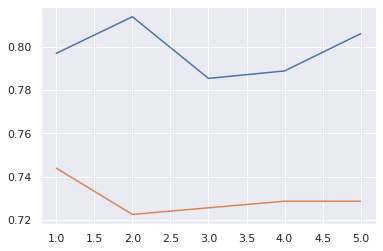

In [25]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.lineplot(x=[1,2,3,4,5], y=history.history['acc'])
ax = sns.lineplot(x=[1,2,3,4,5], y=history.history['val_acc'])

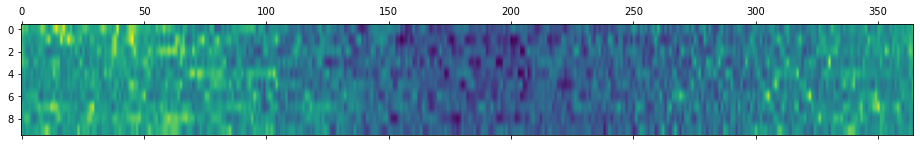

In [2]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('price.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years = years.T
pyplot.matshow(years, interpolation=None, aspect='auto')
pyplot.show()


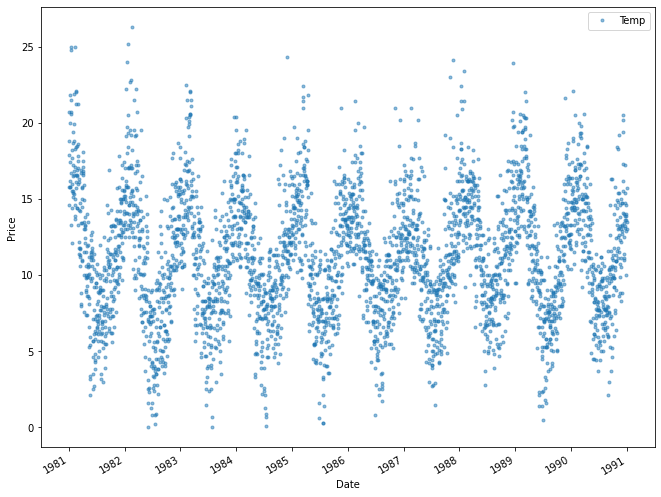

In [4]:
import pandas as pd
opsd_daily = pd.read_csv('price.csv', index_col=0, parse_dates=True)

cols_plot = ['Temp']
axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Price')